## Pré-processamento e explocação do Modelo de Classificação

In [129]:
# Imports
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
%matplotlib inline

### Baixar os dados do [Fake.br-Corpus](https://github.com/roneysco/Fake.br-Corpus)

*Atenção:* Para rodar localmente, é preciso salvar o pacote Fake.br-Corpus no diretorio do projeto.

In [ ]:
!git clone https://github.com/roneysco/Fake.br-Corpus

Cloning into 'Fake.br-Corpus'...
remote: Enumerating objects: 28763, done.
remote: Total 28763 (delta 0), reused 0 (delta 0), pack-reused 28763
Receiving objects: 100% (28763/28763), 37.10 MiB | 21.02 MiB/s, done.
Resolving deltas: 100% (14129/14129), done.
Checking out files: 100% (21602/21602), done.


### Carregando os dados

Vou utilizar a amostra "size_normalized_texts" do Corpus dado que ela ajuda a evitar viéses no treino, conforme informação disponível na documentação. Cada par de texto verdadeiro ou falso possui a mesma quantidade de palavras, truncando o maior pelo menor.

In [42]:
DADOS_CAMINHO = "./Fake.br-Corpus/size_normalized_texts"

def load_txts(path):
    txts = []
    for filename in sorted(os.listdir(path), key=lambda x: int(re.match("[0-9]+", x).group())):
        with open(os.path.join(path, filename)) as f:
            txts.append(f.read())
    return [txt.rstrip() for txt in txts]

true_txts = load_txts(os.path.join(DADOS_CAMINHO, "true"))
fake_txts = load_txts(os.path.join(DADOS_CAMINHO, "fake"))

#confere se tem a mesma quantidade (dataset é balanceado)
assert(len(true_txts) == len(fake_txts))

dados = pd.DataFrame(
    [{"texto": t, "classe": 0} for t in true_txts] \
         + [{"texto": f, "classe": 1}  for f in fake_txts]
)
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 200)
display(dados[dados['texto'].str.len()<100].sample(n=3)[['classe', 'texto']])

,classe,texto
4248,1,Vaza lista com nomes dos 233 deputados que aprovaram fundo bilionário para campanhas. .
6357,1,Frota posta foto no Instagram e Zé [o babão cuspidor do PT] começa briga nas redes sociais. .
6506,1,Guerra de cuspe? Vídeo mostra filho de Bolsonaro revidando e cuspindo em Jean Wyllys. .


### Exploração e limpeza de dados

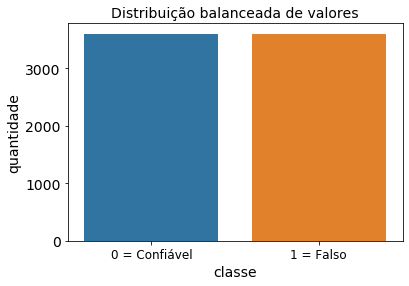

In [43]:
ax = sns.countplot(x="classe", data=dados)
ax.set_xticklabels(["0 = Confiável", "1 = Falso"], fontsize=12)
ax.set_title('Distribuição balanceada de valores', fontsize=14)
ax.set_ylabel('quantidade')
plt.show()

In [44]:
def distribuicao_palavras(texto):
    qtdes = []
    for linha in texto:
        qtdes.append(len(re.findall(r"[\w']+|[.,!?;:/\"]", linha)))
    return np.array(qtdes)

def distribiucao_palavras(dados, campo, titulo):
    contagem = distribuicao_palavras(dados[campo].values)
    intervalo = list(range(0, 601, 50))

    plt.figure(figsize=(10,5))
    plt.rcParams.update({'font.size': 14})
    plt.hist(contagem, rwidth=0.9, edgecolor='black', linewidth=1, bins=intervalo)
    plt.xticks(intervalo)
    plt.title(titulo)
    plt.xlabel("Qtde palavras ou pontuação", fontsize=14, fontweight="bold")
    plt.ylabel("Frequência", fontsize=14, fontweight="bold")

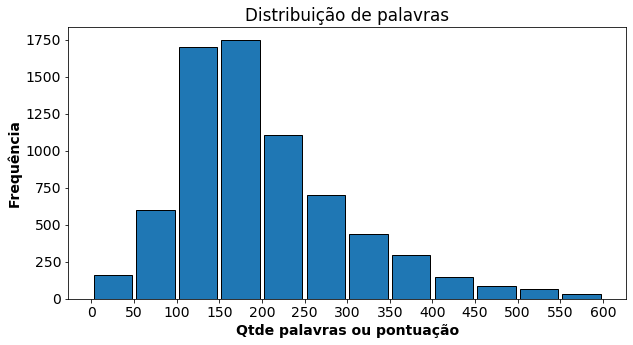

In [45]:
distribiucao_palavras(dados, "texto", "Distribuição de palavras")

In [50]:
# Limpar textos
def limpar_textos(texto):
    texto = str(texto).replace(r'http[\w:/\.]+', ' ')  # remover urls
    texto = str(texto).replace(r'[^\.\w\s]', ' ')  # remover tudo exceto caracters e pontuação
    # Correção das pontuações duplicadas, há muitos casos no dadaset
    texto = re.sub(r'(\W)(?=\1)', '', str(texto))
    texto = str(texto).replace('[^a-zA-Z]', ' ')
    texto = str(texto).replace(r'\s\s+', ' ')
    texto = str(texto).replace(". .", ".").replace(r'\n', '').replace('\n', '')
    return texto.strip()

dados["texto_limpo"] = dados.texto.apply(limpar_textos)
dados.sample(n=5)

,texto,classe,texto_limpo
4317,"Explosão nuclear? Terremoto sacode a Coreia do Norte e atinge 3,4 na escala Richter. . O primeiro tremor foi sentido próximo à capital Pyongyang, onde o ditador Kim Jong-un e seus aliados mais pr...",1,"Explosão nuclear? Terremoto sacode a Coreia do Norte e atinge 3,4 na escala Richter. O primeiro tremor foi sentido próximo à capital Pyongyang, onde o ditador Kim Jong-un e seus aliados mais próxi..."
4745,"EUA: Médicos que chegaram perto de encontrar a cura do câncer estariam ""desaparecendo"" misteriosamente. . Em todo o mundo, 8,2 milhões morrem a cada ano vítimas do câncer. No Brasil de 2016, esti...",1,"EUA: Médicos que chegaram perto de encontrar a cura do câncer estariam ""desaparecendo"" misteriosamente. Em todo o mundo, 8,2 milhões morrem a cada ano vítimas do câncer. No Brasil de 2016, estima-..."
6786,"Joice Hasselmann: "" Lula está me processando por crime contra a honra. Mas que honra? Não entendo"". O vídeo é um bate-papo entre o fundador do Revoltados Online, Marcelo Reis e a jornalista (ex-...",1,"Joice Hasselmann: "" Lula está me processando por crime contra a honra. Mas que honra? Não entendo"". O vídeo é um bate-papo entre o fundador do Revoltados Online, Marcelo Reis e a jornalista (ex-Ve..."
2151,"SELEÇÃO DA TARDE Foto: Matheus Ferreira/divulgação + O gastropub Cão Véio agora serve almoço executivo, de 2ª a 6ª, com oito opções a partir de R$ 32. Uma delas é o ‘Lobo do Mar’ (R$ 36; foto), sa...",0,"SELEÇÃO DA TARDE Foto: Matheus Ferreira/divulgação + O gastropub Cão Véio agora serve almoço executivo, de 2ª a 6ª, com oito opções a partir de R$ 32. Uma delas é o ‘Lobo do Mar’ (R$ 36; foto), sa..."
5184,"Espírito Santo: Número de mortos na capital chega a 95. Cerca de 260 carros foram roubados em 36 horas. . Desde o último dia sábado (04), 95 pessoas foram mortas. Somente hoje (08) sessenta carro...",1,"Espírito Santo: Número de mortos na capital chega a 95. Cerca de 260 carros foram roubados em 36 horas. Desde o último dia sábado (04), 95 pessoas foram mortas. Somente hoje (08) sessenta carros f..."


In [53]:
# Configuração da lib Spacy
!python -m spacy download pt_core_news_sm

     ---------------------------------------- 22.2/22.2 MB 4.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [54]:
# Processamento com Spacy
import pt_core_news_sm
nlp = pt_core_news_sm.load()

# Lemmatizer (o resultado é a raiz da palavra que existe na gramática, mantendo o contexto)
# Stemming (palavra resultante pode não existir, apenas reduz a dimencionalidade) 

# Remover stopwords, pontuação e lematizar 
def processo_spacy(texto):
    retorno = []
    for token in nlp(texto): 
      if not (token.is_stop or token.is_punct):
        retorno.append(token.lemma_)
    return " ".join(retorno)

dados["texto_processado"] = dados.texto_limpo.apply(processo_spacy)

In [73]:
# Confere resultados visualmente
dados.sample(n=5)

,texto,classe,texto_limpo,texto_processado
1865,A Procuradoria-Geral da República (PGR) abriu nova frente de investigação no inquérito do Supremo Tribunal Federal (STF) que apura supostos repasses de propina da Odebrecht para o grupo do MDB lid...,0,A Procuradoria-Geral da República (PGR) abriu nova frente de investigação no inquérito do Supremo Tribunal Federal (STF) que apura supostos repasses de propina da Odebrecht para o grupo do MDB lid...,Procuradoria-Geral República PGR abrir frente investigação inquérito Supremo Tribunal Federal STF apurar suposto repasse propinar Odebrecht MDB liderar presidente Michel Temer ministro Eliseu Padi...
739,"O homem mais poderoso do mundo. Xi Jinping é um líder mais influente do que Donald Trump, e isso deveria deixar o mundo preocupado. Os presidentes americanos têm o hábito de falar com certo assomb...",0,"O homem mais poderoso do mundo. Xi Jinping é um líder mais influente do que Donald Trump, e isso deveria deixar o mundo preocupado. Os presidentes americanos têm o hábito de falar com certo assomb...",homem poderoso mundo Xi Jinping líder influente Donald Trump dever deixar mundo preocupar presidente americano hábito falar certar assombrar colega chinês Richard Nixon bajulador dizer Mao Tsé-tun...
2389,MDB tenta colar Meirelles em plano eleitoral de Temer. Cúpula do partido vê o ministro da Fazenda como alternativa caso candidatura do presidente não ganhe força nos próximos meses. BRASÍLIA - Dep...,0,MDB tenta colar Meirelles em plano eleitoral de Temer. Cúpula do partido vê o ministro da Fazenda como alternativa caso candidatura do presidente não ganhe força nos próximos meses. BRASÍLIA - Dep...,MDB tentar colar Meirelles planar eleitoral Temer Cúpula partir ver ministrar Fazenda alternativo casar candidatura presidente ganhar forçar próximo BRASÍLIA confirmar ser candidatar mandatar pres...
2856,"PF conclui inquérito da Acrônimo e indicia Luciano Coutinho e primeira-dama de MG. Fernando Pimentel não foi indiciado por ter foro privilegiado, mas relatório será analisado pelo STJ. Defesa do g...",0,"PF conclui inquérito da Acrônimo e indicia Luciano Coutinho e primeira-dama de MG. Fernando Pimentel não foi indiciado por ter foro privilegiado, mas relatório será analisado pelo STJ. Defesa do g...",PF concluir inquérito Acrônimo indiciar Luciano Coutinho primeira-dama MG Fernando Pimentel indiciar foro privilegiar relatório ser analisar STJ Defesa governador dizer tratar casar emblemático ex...
4826,"Paulo Henrique Amorim: ""Aécio Neves é um gangster filhinho de papai"". ""É provável que o Marcola e o Fernandinho Beira-Mar tenham uma linguagem mais elevada que Aécio"". (*** dessa vez temos que t...",1,"Paulo Henrique Amorim: ""Aécio Neves é um gangster filhinho de papai"". ""É provável que o Marcola e o Fernandinho Beira-Mar tenham uma linguagem mais elevada que Aécio"". (* dessa vez temos que tirar...",Paulo Henrique Amorim Aécio Neves gangster filho papar provável Marcola Fernandinho Beira-Mar ter linguagem elevar Aécio tirar chapéu PHA PHA petista carteira possuir diverso processo lombo soltar...


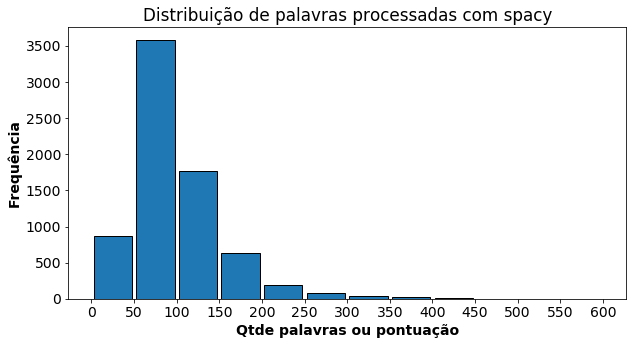

In [74]:
# A distribuição mudou e temo ter problemas de viés com a frases mais longas
distribiucao_palavras(dados, "texto_processado", "Distribuição de palavras processadas com spacy")

In [75]:
dados["qtde_texto_limpo"] = dados.texto_limpo.apply(lambda texto: len(re.findall(r"[\w']+|[.,!?;:/\"]", texto)))
dados["qtde_texto_processado"] = dados.texto_processado.apply(lambda texto: len(re.findall(r"[\w']+|[.,!?;:/\"]", texto)))
dados.sample(n=3)

,texto,classe,texto_limpo,texto_processado,qtde_texto_limpo,qtde_texto_processado
2851,Cármen Lúcia nega pedido de Aécio e mantém ação sobre afastamento do mandato com Fachin. Presidente do Supremo Tribunal Federal negou o pedido da defesa para mudar o relator. Aécio foi afastado do...,0,Cármen Lúcia nega pedido de Aécio e mantém ação sobre afastamento do mandato com Fachin. Presidente do Supremo Tribunal Federal negou o pedido da defesa para mudar o relator. Aécio foi afastado do...,Cármen Lúcia negar pedir Aécio manter ação afastamento mandatar Fachin Presidente Supremo Tribunal Federal negar pedir defeso mudar relator Aécio afastar mandatar semana passar presidente Supremo ...,114,64
5783,"Jornalista da Globo não percebeu que estava ao vivo e tirou os sapatos durante telejornal. Leilane Neubarth, do canal GloboNews, se esqueceu que estava ao vivo e liberou geral!. Na edição do j...",1,"Jornalista da Globo não percebeu que estava ao vivo e tirou os sapatos durante telejornal. Leilane Neubarth, do canal GloboNews, se esqueceu que estava ao vivo e liberou geral!. Na edição do jorna...",Jornalista Globo perceber viver tirar sapato durante telejornal Leilane Neubarth canal GloboNews esquecer viver liberar edição jornal 09 jornalista tirar sapato viver levar público internet loucur...,135,52
2426,"Comerciantes da Vila Kennedy poderão voltar ao trabalho nesta segunda. Prefeito do Rio, Marcelo Crivella, se reuniu neste sábado (10) com comerciantes da Praça Miami que tiveram quiosques derrubad...",0,"Comerciantes da Vila Kennedy poderão voltar ao trabalho nesta segunda. Prefeito do Rio, Marcelo Crivella, se reuniu neste sábado (10) com comerciantes da Praça Miami que tiveram quiosques derrubad...",Comerciantes Vila Kennedy poder voltar trabalhar Prefeito Rio Marcelo Crivella reunir sábado 10 comerciante Praça Miami quiosque derrubar agente municipal comerciante Vila Kennedy Zona Oeste Rio p...,108,56


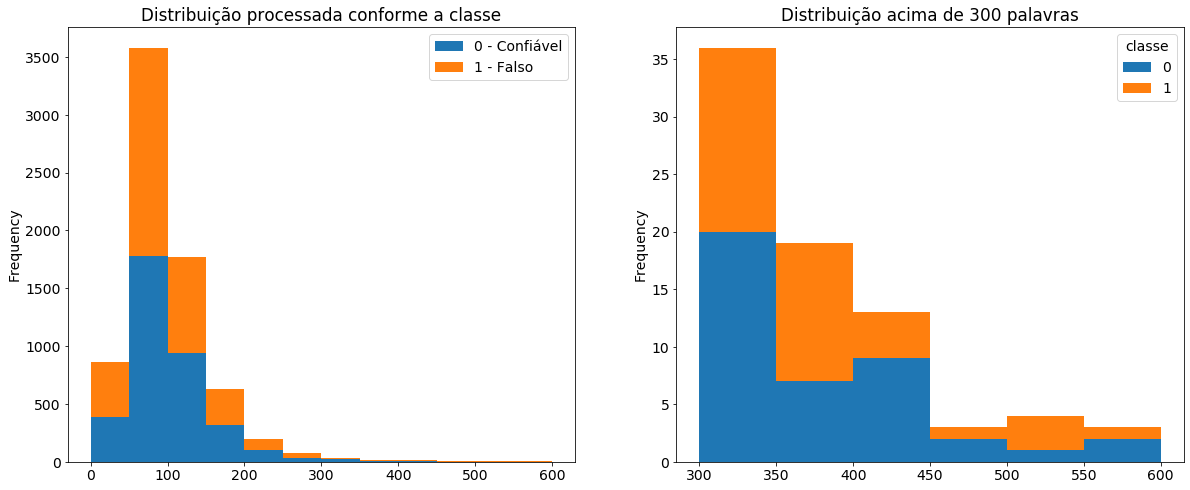

In [96]:
dfplot = dados.pivot(columns='classe').qtde_texto_processado
dfplot.columns = ['0 - Confiável', '1 - Falso']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
axes1 = dfplot.plot(
    ax=axes[0], kind='hist', stacked=True, bins=list(range(0, 601, 50)), 
    title="Distribuição processada conforme a classe")
evitar_bias = dados[dados['qtde_texto_processado'] > 300]
axes2 = evitar_bias.pivot(columns='classe').qtde_texto_processado.plot(
    ax=axes[1], kind='hist', stacked=True, bins=list(range(300, 601, 50)), 
    title="Distribuição acima de 300 palavras")

In [97]:
display(f"Total de amostras: {dados.shape[0]}", f"Amostras com muitas palavras: {evitar_bias.shape[0]}")
display("0 = Confiável;  1 = Falso")
display(evitar_bias.groupby('classe').qtde_texto_processado.count())

'Total de amostras: 7200'

'Amostras com muitas palavras: 84'

'0 = Confiável;  1 = Falso'

classe
0    44
1    40
Name: qtde_texto_processado, dtype: int64

In [100]:
# testes do ponto de corte
dados[(dados['qtde_texto_processado'] < 350)].groupby('classe').qtde_texto_processado.count()

classe
0    3576
1    3576
Name: qtde_texto_processado, dtype: int64

In [101]:
# Encontrei um ponto de corte que manteve o balanceamento perfeito da base
dados = dados[(dados['qtde_texto_processado'] < 350)]

### Pesquisando se alguma palavra se destaca demais e pode gerar viés

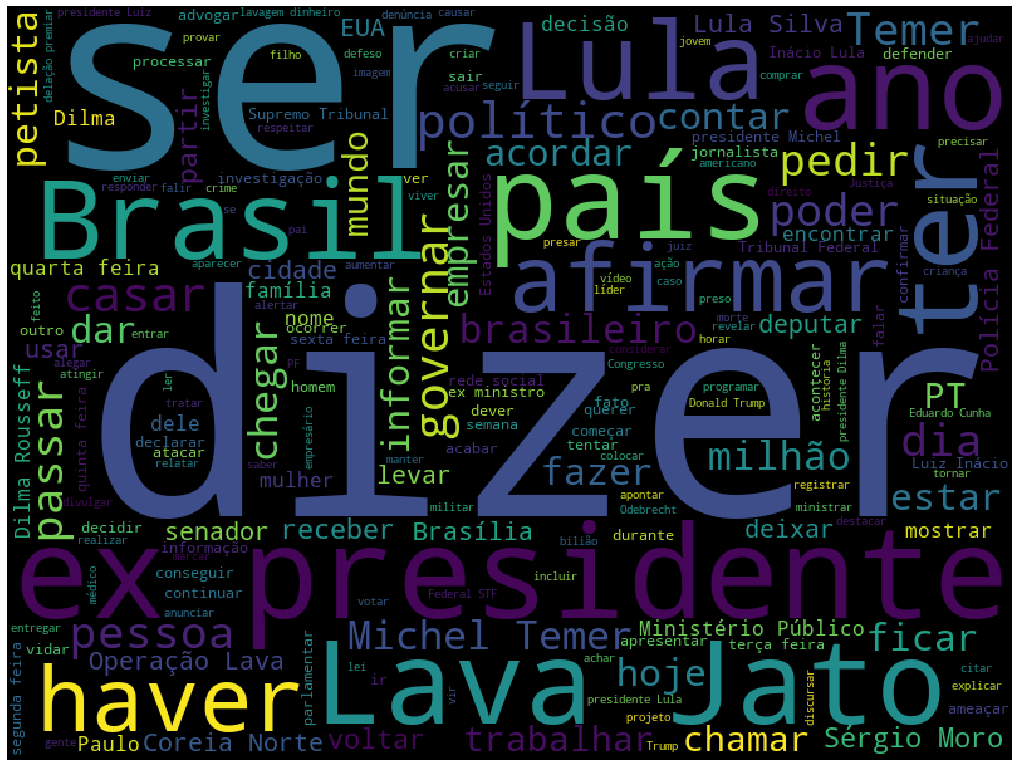

In [118]:
# Avaliar as palavras mais usadas em todo dataset
wordcloud_full = WordCloud( background_color='black', width=800, height=600)
nuvem = wordcloud_full.generate(' '.join(dados['texto_processado']))
plt.figure(figsize=(18,25))
plt.imshow(nuvem)
plt.axis('off')
plt.show()

In [119]:
# Gera nuvem de palavras para cada grupo
wc_confiavel = WordCloud( background_color='black', width=800, height=600)
lista_confiavel = ' '.join(dados[dados['classe']==0]['texto_processado'])
nuvem_confiavel = wc_confiavel.generate(lista_confiavel)
wc_falsa = WordCloud( background_color='black', width=800, height=600)
lista_falsa = ' '.join(dados[dados['classe']==1]['texto_processado'])
nuvem_falsa = wc_falsa.generate(lista_falsa)

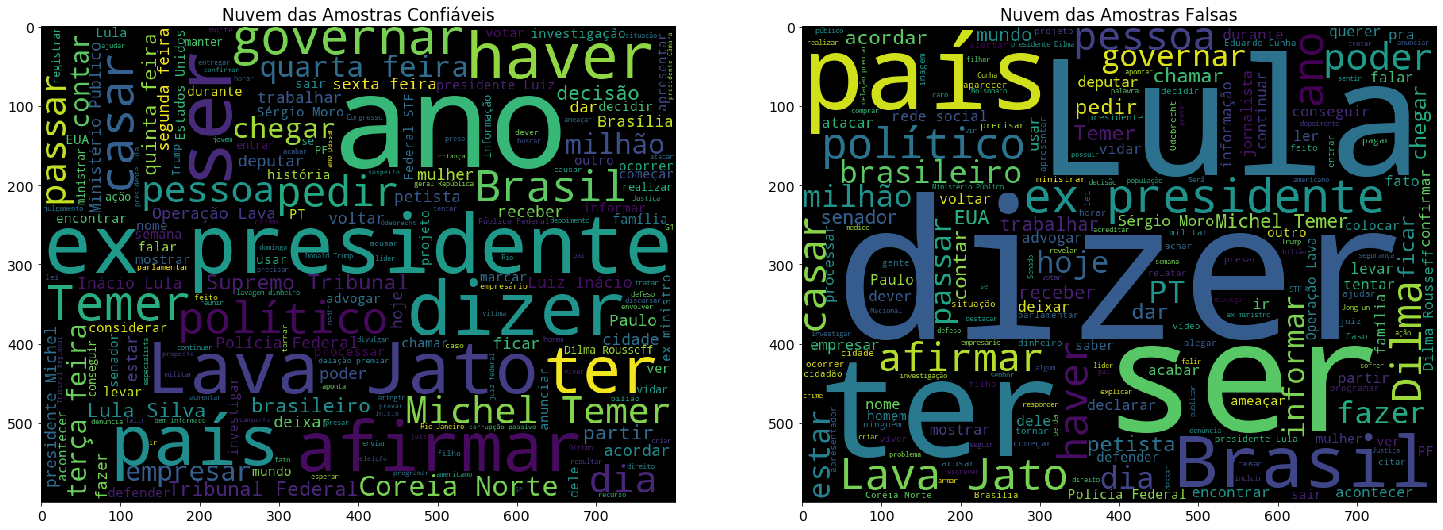

In [127]:
# Plots núvens lado a lado para comparar
f, plots = plt.subplots(nrows=1, ncols=2, figsize=(25, 45))
plots[0].imshow(nuvem_confiavel)
plots[0].set_title('Nuvem das Amostras Confiáveis')
plots[1].imshow(nuvem_falsa)
plots[1].set_title('Nuvem das Amostras Falsas')
plt.show()

In [160]:
import nltk
def avaliar_ngrams(corpus, title, n=2, top=20, plot_pos=None):
  serie_plot = (pd.Series(nltk.ngrams(corpus.split(), n)).value_counts())[:top]
  serie_plot.sort_values().plot.barh(color='blue', width=.9, ax=plot_pos, title=title, figsize=(24, 8))

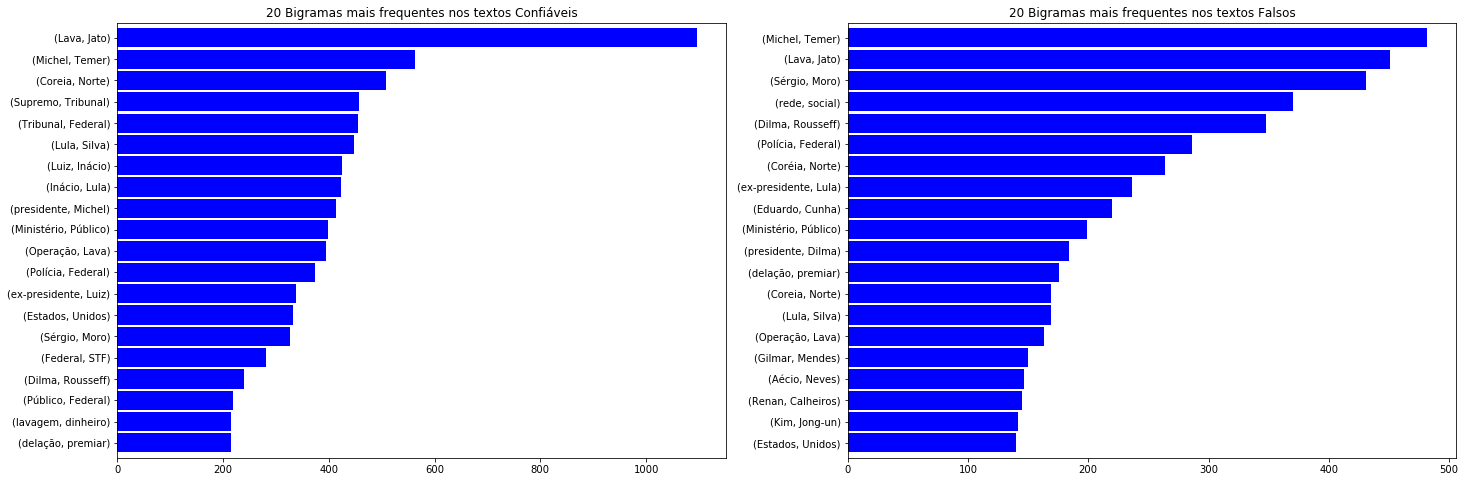

In [161]:
fig, axes = plt.subplots(nrows=1, ncols=2)
avaliar_ngrams(lista_confiavel, '20 Bigramas mais frequentes nos textos Confiáveis', plot_pos=axes[0])
avaliar_ngrams(lista_falsa, '20 Bigramas mais frequentes nos textos Falsos', plot_pos=axes[1])
#Penso em futuramente remover Michel Temer e Lava Jato pelo menos para tentar reduzir viés

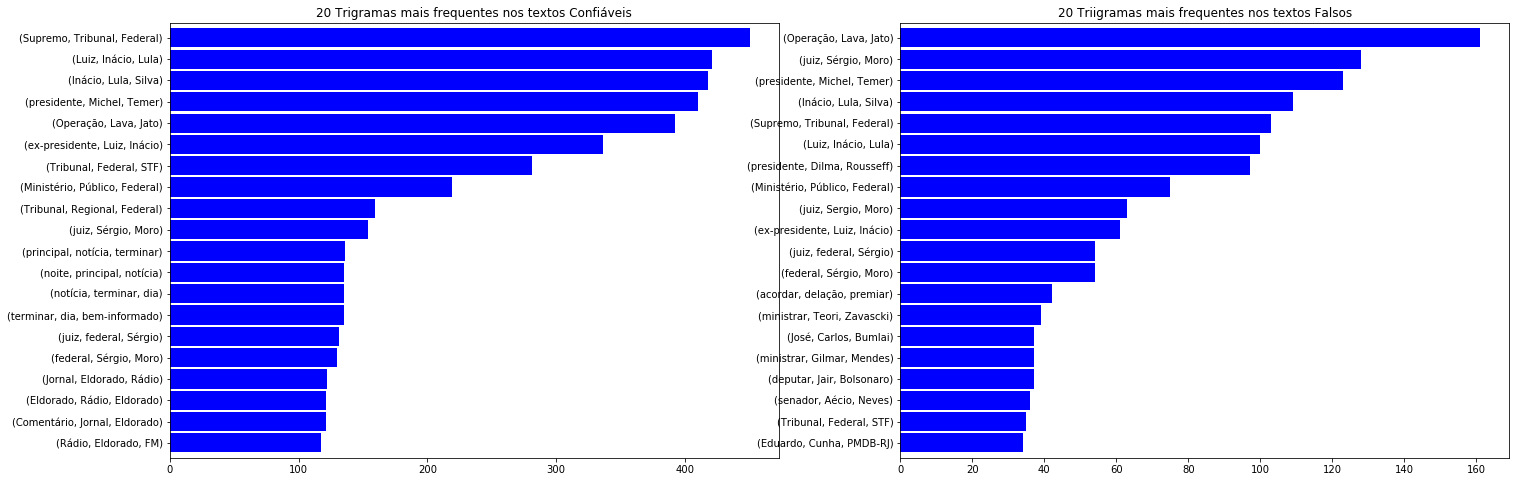

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=2)
avaliar_ngrams(lista_confiavel, '20 Trigramas mais frequentes nos textos Confiáveis', n=3, plot_pos=axes[0])
avaliar_ngrams(lista_falsa, '20 Triigramas mais frequentes nos textos Falsos', n=3, plot_pos=axes[1])
#Com a visualização das trigramas dificulta fazer cortes, mas vejo que algumas trigramas se repetem em ordem diferente, 
# espero que o modelo BERT lide bem com isto, pois aqui estou usando o NLTK

In [164]:
# Salva dados para uso no notebook do próximo passo.
os.makedirs("dados/", exist_ok=True)
dados.to_csv('dados/fakebr_corpus_processado.csv', sep = ',', index = True)